In [70]:
import numpy as np , pandas as pd
from lightning_fabric.utilities.seed import seed_everything
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
    (LinearRegression ,
     LogisticRegression ,
     Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
    (train_test_split ,
     GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError ,
                          R2Score)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# from pytorch_lightning.utilities.seed import seed_everything

from torchvision.datasets import MNIST , CIFAR100
from torchvision.models import (resnet50 ,
                                ResNet50_Weights)
from torchvision.transforms import (Resize ,
                                    Normalize ,
                                    CenterCrop ,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule ,
                        SimpleModule ,
                        ErrorTracker ,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup ,
                             load_tensor ,
                             load_sparse ,
                             load_sequential)
from glob import glob
import json

In [71]:
seed_everything(0, workers=True)
torch.use_deterministic_algorithms (True , warn_only=True)

Seed set to 0


# Hitters

In [72]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]
n

263

In [73]:
model_spec = MS(Hitters.columns.drop("Salary"), intercept=False)
X = model_spec.fit_transform(Hitters).to_numpy()
y = Hitters["Salary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, random_state=1)

In [74]:
hit_lr = LinearRegression().fit(X_train, y_train)
pred = hit_lr.predict(X_test)
MAE_LR = np.abs(pred - y_test).mean()
MAE_LR

259.7152883314631

In [75]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30_000)
standard_lasso = Pipeline([
    ('scaler', scaler),
    ('lasso', lasso),
])

X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(y_train - y_train.mean())).max() / n
cv = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(
    lasso,
    {"alpha": np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max},
    cv=cv,
    scoring="neg_mean_absolute_error",
)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [76]:
trained_lasso = grid.best_estimator_
pred = trained_lasso.predict(X_test)
MAE_lasso = np.abs(pred - y_test).mean()
MAE_lasso

257.23820107995

## Neural Network

In [77]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.sequential(x)
        return torch.flatten(x)

In [78]:
hit_model = HittersModel(X.shape[1])
summary(hit_model, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [79]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
train_ds = TensorDataset(X_train_t, y_train_t)

In [80]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
test_ds = TensorDataset(X_test_t, y_test_t)

In [81]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [82]:
hit_dm = SimpleDataModule(train_ds, test_ds, batch_size=32, num_workers=min(4, max_num_workers), validation=test_ds)
hit_dm

In [83]:
hit_module = SimpleModule.regression(hit_model, metrics={"mae": MeanAbsoluteError()})

In [84]:
hit_logger = CSVLogger("logs", name="hitters")

In [85]:
hit_trainer = Trainer(
    deterministic=True,
    max_epochs=50,
    log_every_n_steps=5,
    logger=hit_logger,
    callbacks=[ErrorTracker()],
)
hit_trainer.fit(hit_module, datamodule=hit_dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 142.19it/s, v_num=1]            
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 167.96it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 128.76it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 139.97it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 139.04it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 6/6 [00:00<00:00, 175.90it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 6/6 [00:00<00:00, 141.46it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 6/6 [00:00<00:00, 161.70it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 133.94i

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 99.52it/s, v_num=1] 


In [86]:
def summary_plot(results ,
                 ax ,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss ',
                 fontsize =20):
    for (column ,
         color ,
         label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend, valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

In [87]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

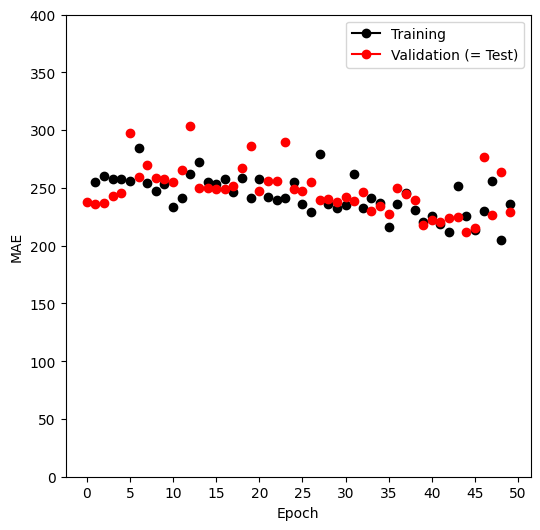

In [88]:
fig , ax = subplots (1, 1, figsize =(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (= Test)')
ax.set_ylim ([0, 400])
ax.set_xticks(np.linspace (0, 50, 11).astype(int));

In [89]:
hit_model.eval ()
preds = hit_module(X_test_t)
MAE_nn = torch.abs(preds - y_test_t).mean()
MAE_nn

tensor(229.5012, grad_fn=<MeanBackward0>)

# Mnist

In [90]:
mnist_train, mnist_test = [MNIST(root='data',
       train=train ,
       download=True ,
       transform=ToTensor ())
 for train in [True , False ]]

mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [91]:
mnist_dm = SimpleDataModule (mnist_train ,
                             mnist_test ,
                             validation =0.2,
                             num_workers=max_num_workers ,
                             batch_size =256)